# Setup Environment

In [4]:
!pip install keras_unet_collection
!pip install segmentation_models

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 67.9/67.9 kB 3.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 50.7/50.7 kB 4.3 MB/s eta 0:00:00


In [5]:
!pip install -- tensorflow_model_optimization

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 242.5/242.5 kB 8.2 MB/s eta 0:00:00


In [6]:
!pip install onnxruntime
!pip install git+https://github.com/onnx/tensorflow-onnx

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.8/6.8 MB 50.4 MB/s eta 0:00:0000:0100:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 46.0/46.0 kB 4.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 86.8/86.8 kB 10.0 MB/s eta 0:00:00
  Cloning https://github.com/onnx/tensorflow-onnx to /tmp/pip-req-build-pw43onkq
  Running command git clone --filter=blob:none --quiet https://github.com/onnx/tensorflow-onnx /tmp/pip-req-build-pw43onkq
  Resolved https://github.com/onnx/tensorflow-onnx to commit ed022438576ca7a351c3858105439f4f25c35219
  Preparing metadata (setup.py) ... done
  Created wheel for tf2onnx: filename=tf2onnx-1.16.1-py3-none-any.whl size=455819 sha256=67f2d72cc5d55bcfdea7da8d0ddac854c970267eb825266f755da9c1cee52ae1
  Stored in directory: /tmp/pip-ephem-wheel-cache-cxtsuga4/wheels/42/b4/7f/f00be6b8e1adcc24edcdd0d778f3416f568de22479ed30aab8
Successfully built tf2onnx


In [7]:
import tifffile
import tempfile
import time 
import os
import numpy as np 
import matplotlib.pyplot as plt
import cv2
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import binary_crossentropy
from tensorflow.keras.metrics import binary_accuracy
import tensorflow.keras.backend as K
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from keras_unet_collection.models import r2_unet_2d
from tensorflow.keras.callbacks import TensorBoard, CSVLogger, ModelCheckpoint, Callback, LearningRateScheduler, EarlyStopping

import tensorflow_model_optimization as tfmot

import onnx
import tf2onnx
import onnxruntime as ort

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


# Load Dataset

In [8]:
# Fetch Dataset into the current directory and point the /images and /annotations
image_path=['./images/'+i for i in os.listdir('./images')]
mask_path=['./annotations/'+i for i in os.listdir('./annotations')]

In [9]:
# Train-Validation ratio of 0.8:0.2
train_img_path=image_path[:int(0.8*len(image_path))]
train_msk_path=mask_path[:int(0.8*len(mask_path))]
val_img_path=image_path[int(0.8*len(image_path)):]
val_msk_path=mask_path[int(0.8*len(mask_path)):]

In [11]:
# Create CustomDataLoader class
class CustomDataLoader(keras.utils.Sequence):
    def __init__(self, img_path,msk_path, batch_size=8, input_shape=(256,256,4), shuffle=True):
        self.image_paths = img_path
        self.mask_paths =  msk_path
        self.batch_size = batch_size
        self.input_shape = input_shape
        self.shuffle = shuffle
        self.indexes = np.arange(len(self.image_paths))

    def __len__(self):
        return int(np.ceil(len(self.image_paths) / self.batch_size))

    def on_epoch_end(self):
        if self.shuffle:
            np.random.shuffle(self.indexes)

    def __getitem__(self, index):
        batch_image_paths = self.image_paths[index * self.batch_size:(index + 1) * self.batch_size]
        batch_mask_paths = self.mask_paths[index * self.batch_size:(index + 1) * self.batch_size]
        
        X = np.zeros((len(batch_image_paths), *self.input_shape), dtype=float)
        y = np.zeros((len(batch_mask_paths), *self.input_shape[:-1], 1), dtype=float)
        
        for i in range(len(batch_image_paths)):
            image = tifffile.imread(batch_image_paths[i])
            red_band = image[:, :, 0]
            green_band =image[:, :, 1]
            blue_band = image[:, :, 2]
            nir_band = image[:, :, 3]
            ndwi = (green_band - nir_band) / (green_band + nir_band)
            ndwi =ndwi>0.01
            X[i] = np.stack([red_band, green_band, blue_band, ndwi], axis=-1)
            y[i] = np.expand_dims(tifffile.imread(batch_mask_paths[i]), axis=-1)

        return X, y


In [12]:
# Define Training and Validation DataLoader
train_loader=CustomDataLoader(train_img_path,train_msk_path)
val_loader=CustomDataLoader(val_img_path,val_msk_path)

# Visualize validation data

In [ ]:
sample_batch = val_loader[0]

images, masks = sample_batch
print(images.shape,masks.shape)
for i in range(len(images)):
    plt.figure(figsize=(12, 6))
    
    plt.subplot(1, 2, 1)
    plt.imshow(images[i][:,:,:3])
    plt.title('Image')
    plt.axis('off')

    plt.subplot(1, 2, 2)
    plt.imshow(masks[i][:, :, 0], cmap='gray')  
    plt.title('Mask')
    plt.axis('off')

    plt.show()

# R2-UNet model setup

In [13]:
model1 = r2_unet_2d((256,256, 4), [16, 32, 64, 128, 256,512],
                   n_labels=1,
                   stack_num_down=2,
                   stack_num_up=1,
                   recur_num=2,
                   activation='ReLU',
                   output_activation='Sigmoid',
                   batch_norm=True,
                   pool='max',
                   unpool='nearest',
                   name='r2unet')

In [14]:
def iou_loss(y_true, y_pred):
    intersection = K.sum(K.abs(y_true * y_pred), axis=-1)
    union = K.sum(y_true, axis=-1) + K.sum(y_pred, axis=-1) - intersection
    iou = (intersection + 1e-15) / (union + 1e-15)
    return 1 - iou

def iou_metric(y_true, y_pred):
    intersection = K.sum(K.abs(y_true * y_pred), axis=-1)
    union = K.sum(y_true, axis=-1) + K.sum(y_pred, axis=-1) - intersection
    iou = (intersection + 1e-15) / (union + 1e-15)
    return iou
def dice_coef(y_true, y_pred):
    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)
    intersection = K.sum(y_true_f * y_pred_f)
    return (2. * intersection + 1) / (K.sum(y_true_f) + K.sum(y_pred_f) + 1)


def dice_coef_loss(y_true, y_pred):
    return 1 - dice_coef(y_true, y_pred)

model1.compile(optimizer=Adam(lr=0.001), loss=dice_coef_loss, metrics=[dice_coef, binary_accuracy])


# R2-UNet model training

In [15]:
history = model1.fit(train_loader, epochs=1,
                    validation_data=val_loader,verbose=1)

77/77 [==============================] - 70s 327ms/step - loss: 0.6682 - dice_coef: 0.3317 - binary_accuracy: 0.9253 - val_loss: 0.9727 - val_dice_coef: 0.0272 - val_binary_accuracy: 0.0142


1/1 [==============================] - 1s 1s/step


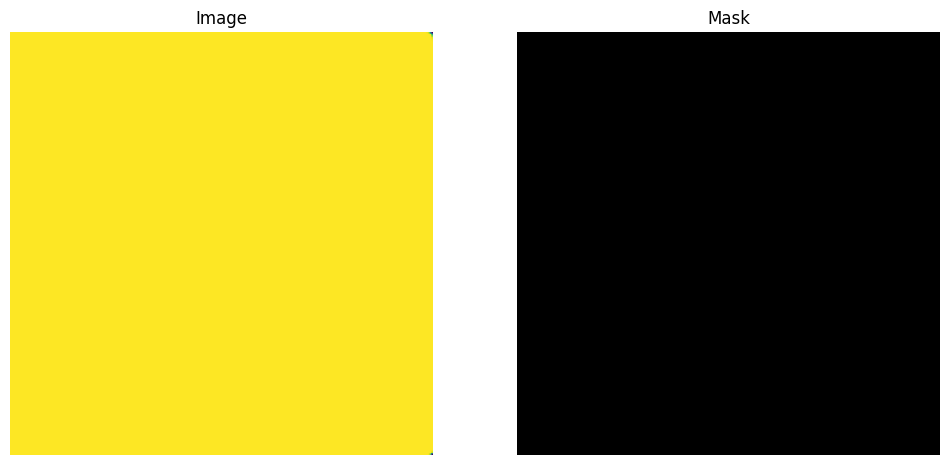

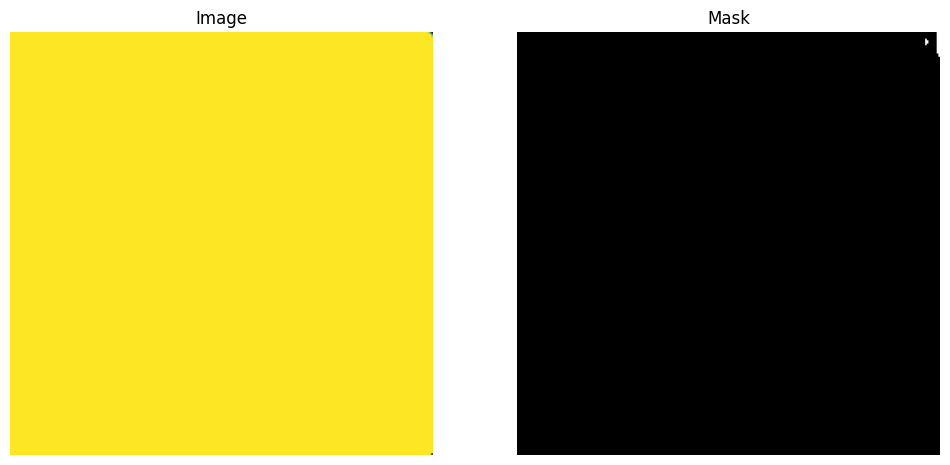

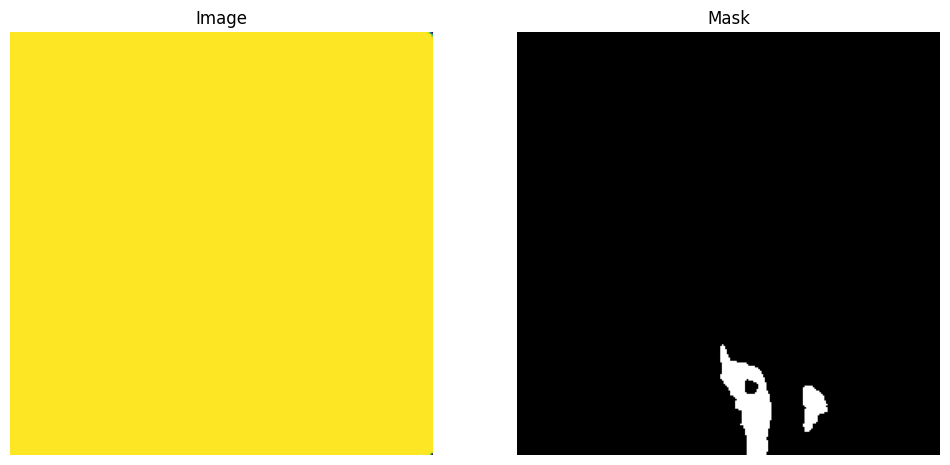

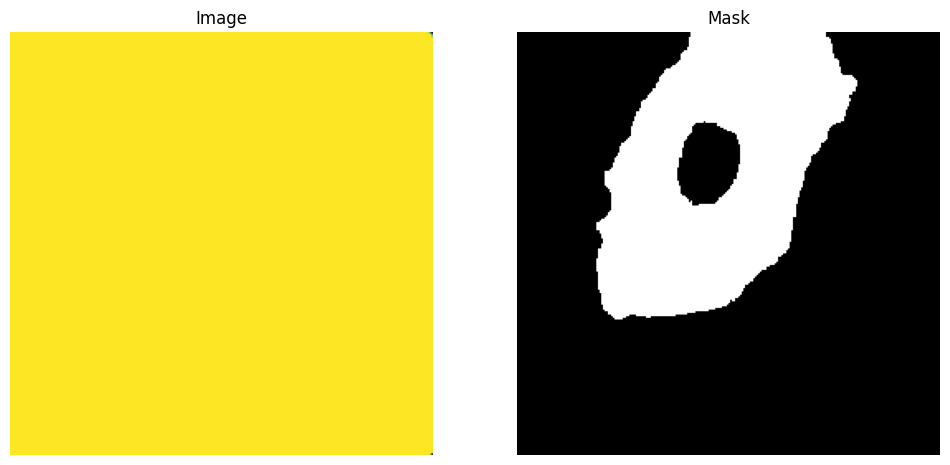

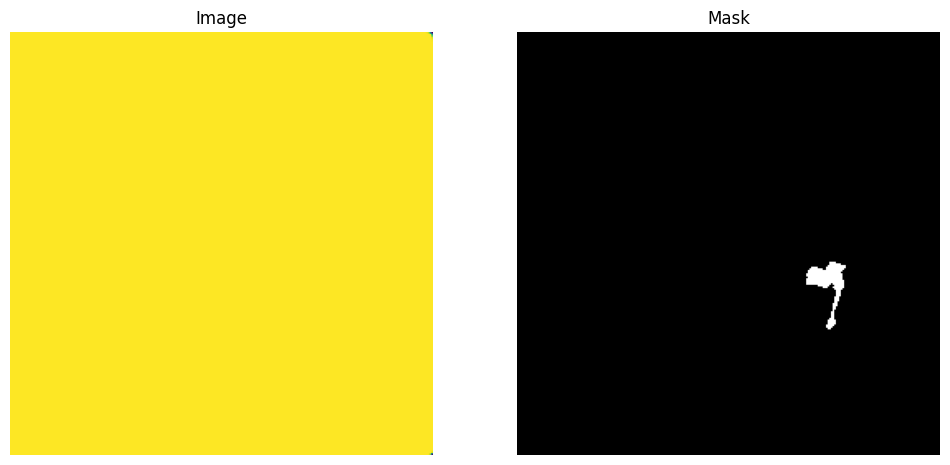

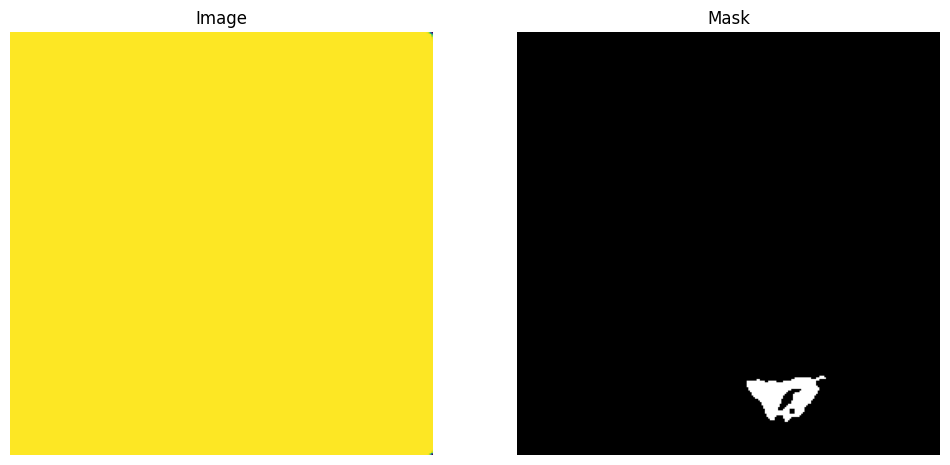

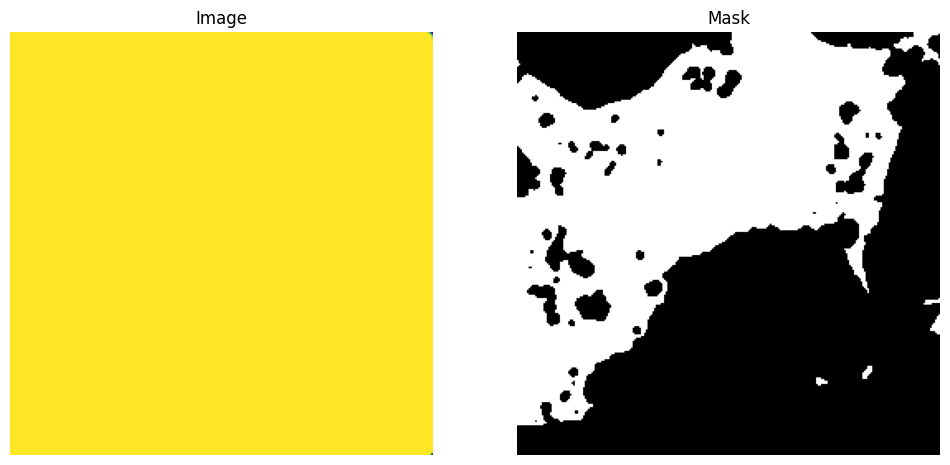

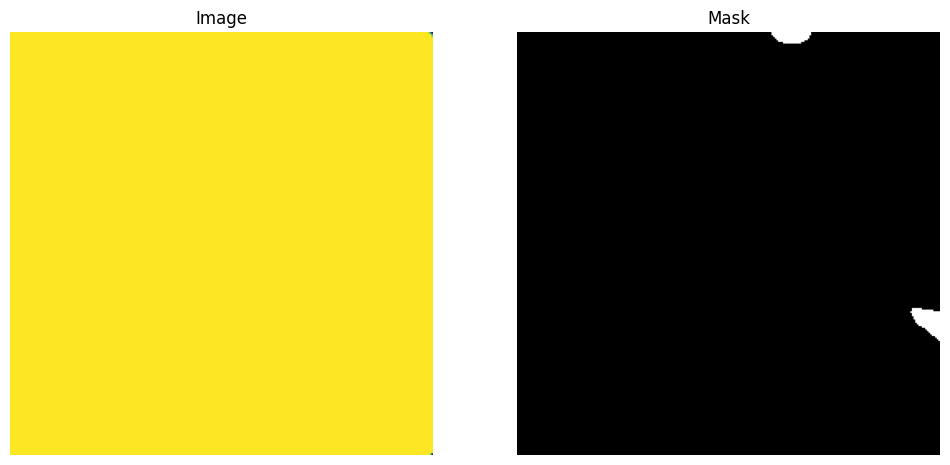

In [16]:
idx=5
sample_batch = val_loader[idx]
images, masks = sample_batch
out=model1.predict(images)
sample_batch = val_loader[idx]


images, masks = sample_batch
for i in range(len(images)):
    plt.figure(figsize=(12, 6))

    plt.subplot(1, 2, 1)
    plt.imshow(out[i])
    plt.title('Image')
    plt.axis('off')

    plt.subplot(1, 2, 2)
    plt.imshow(masks[i][:, :, 0], cmap='gray')  # Assuming binary masks
    plt.title('Mask')
    plt.axis('off')

    plt.show()

# R2-UNet model pruning

In [17]:
pruning_params = {
    'pruning_schedule': tfmot.sparsity.keras.PolynomialDecay(
        initial_sparsity=0.2,
        final_sparsity=0.8,   
        begin_step=0,
        end_step=5000
    )
}

model_for_pruning = tfmot.sparsity.keras.prune_low_magnitude(model1, **pruning_params)
model_for_pruning.compile(optimizer='adam', loss=dice_coef_loss, metrics=['accuracy'])
model_for_pruning.summary()
model_for_pruning.save("unpruned_r2unet.h5")

Model: "r2unet_model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 r2unet_input (InputLayer)      [(None, 256, 256, 4  0           []                               
                                )]                                                                
                                                                                                  
 prune_low_magnitude_r2unet_dow  (None, 256, 256, 16  146        ['r2unet_input[0][0]']           
 n0_conv (PruneLowMagnitude)    )                                                                 
                                                                                                  
 prune_low_magnitude_r2unet_dow  (None, 256, 256, 16  4626       ['prune_low_magnitude_r2unet_down
 n0_conv0 (PruneLowMagnitude)   )                                0_conv[0][0]']        

In [18]:
callbacks = [
  tfmot.sparsity.keras.UpdatePruningStep(),
]

history_prune=model_for_pruning.fit(train_loader, epochs=20,
                    validation_data=val_loader,verbose=1,callbacks=callbacks)

Epoch 1/20
77/77 [==============================] - 113s 234ms/step - loss: 0.3732 - accuracy: 0.9895 - val_loss: 0.9964 - val_accuracy: 0.9858
Epoch 2/20
77/77 [==============================] - 15s 197ms/step - loss: 0.2513 - accuracy: 0.9936 - val_loss: 0.9942 - val_accuracy: 0.9858
Epoch 3/20
77/77 [==============================] - 15s 197ms/step - loss: 0.2462 - accuracy: 0.9937 - val_loss: 0.9338 - val_accuracy: 0.9865
Epoch 4/20
77/77 [==============================] - 15s 193ms/step - loss: 0.2360 - accuracy: 0.9935 - val_loss: 0.9497 - val_accuracy: 0.9692
Epoch 5/20
77/77 [==============================] - 15s 195ms/step - loss: 0.2153 - accuracy: 0.9943 - val_loss: 0.8747 - val_accuracy: 0.9870
Epoch 6/20
77/77 [==============================] - 15s 193ms/step - loss: 0.2074 - accuracy: 0.9948 - val_loss: 0.7920 - val_accuracy: 0.9879
Epoch 7/20
77/77 [==============================] - 15s 197ms/step - loss: 0.2013 - accuracy: 0.9947 - val_loss: 0.8142 - val_accuracy: 0.987

In [19]:
import tensorflow as tf

In [20]:
model_for_export = tfmot.sparsity.keras.strip_pruning(model_for_pruning)
_, pruned_keras_file = tempfile.mkstemp('.h5')
tf.keras.models.save_model(model_for_export, pruned_keras_file, include_optimizer=False)
print('Saved pruned Keras model to:', pruned_keras_file)
model_for_export.save('pruned_model_r2unet.h5')

Saved pruned Keras model to: /tmp/tmpn8gnyj6k.h5


In [23]:
prune_r2unet=keras.models.load_model('./working/pruned_model_r2unet.h5')
s=time.time()
prune_r2unet.predict(val_loader)
e=time.time()
print(e-s)

20/20 [==============================] - 2s 54ms/step
2.3759336471557617


1/1 [==============================] - 2s 2s/step


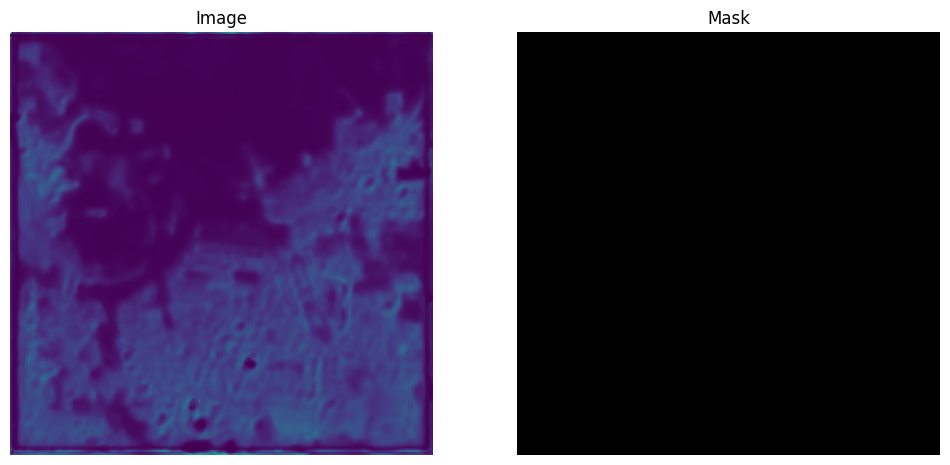

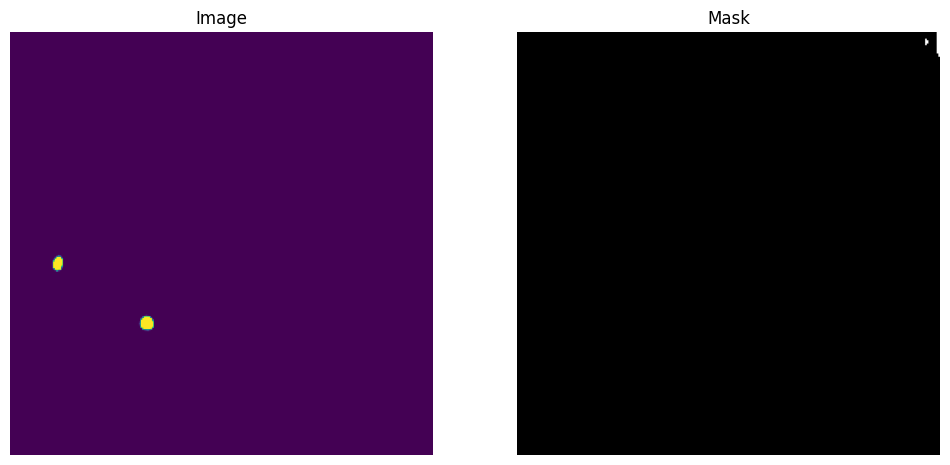

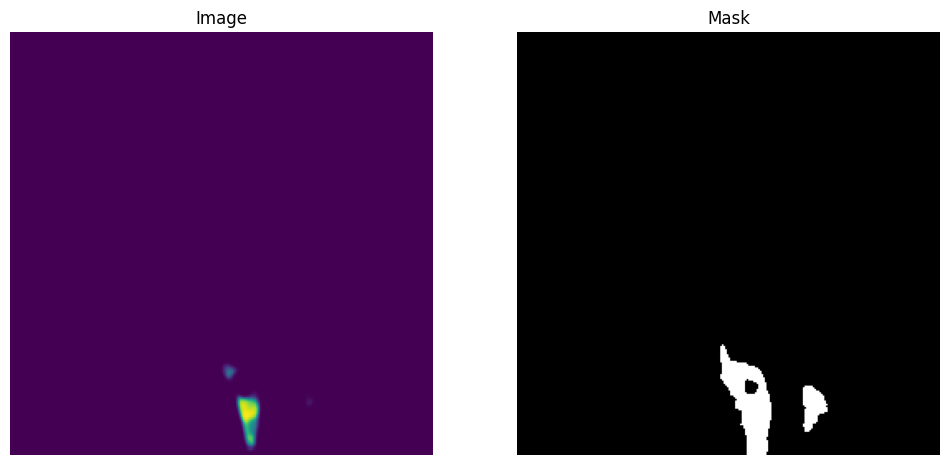

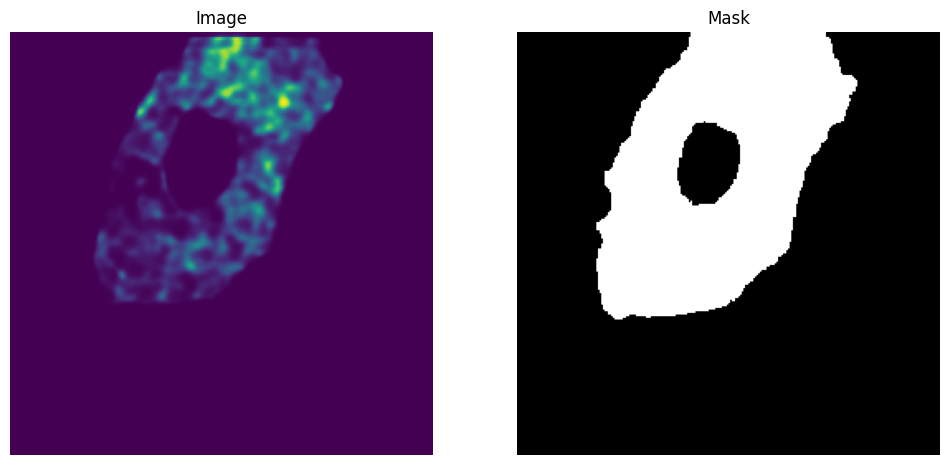

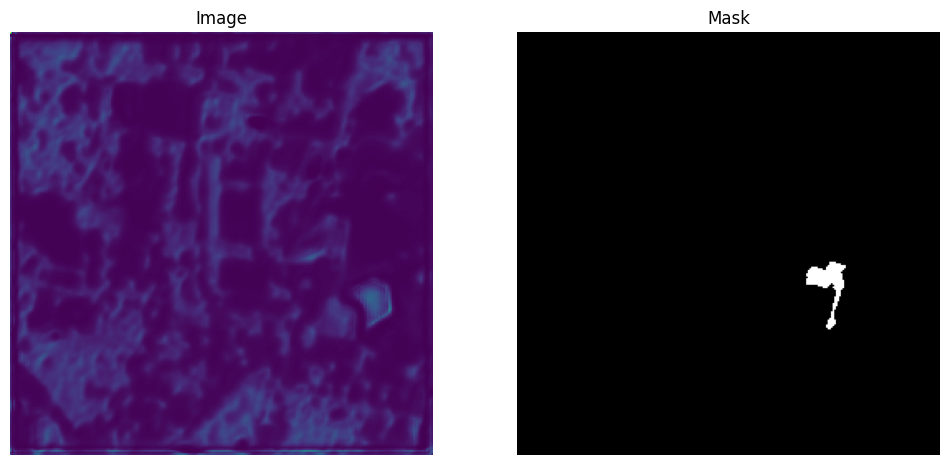

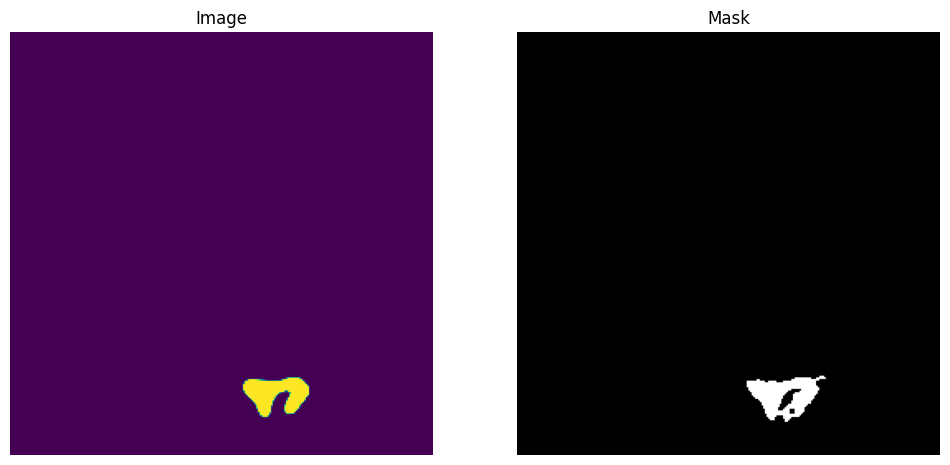

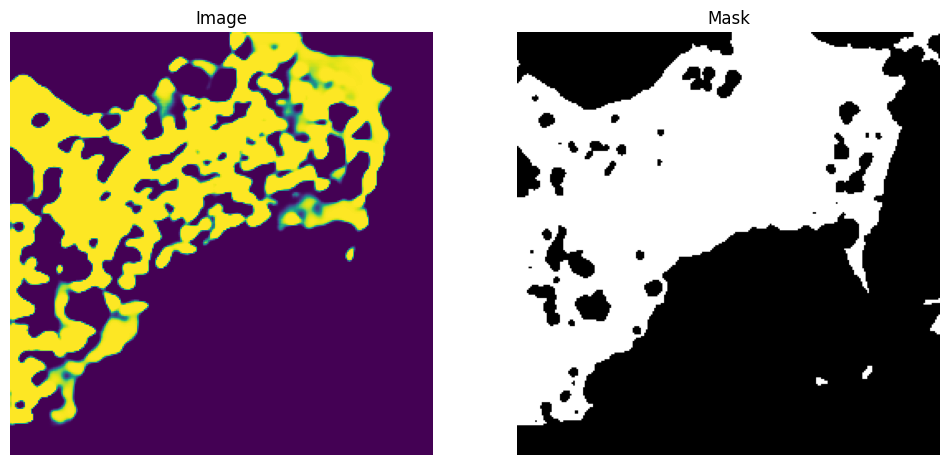

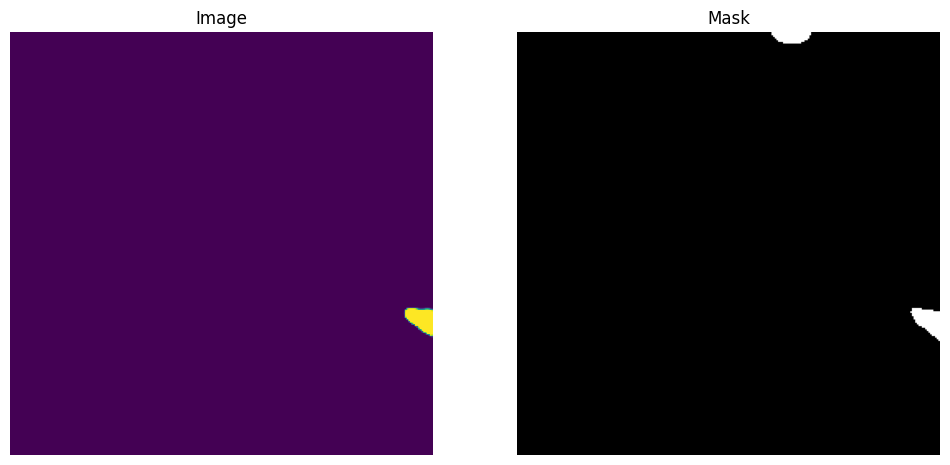

In [24]:
idx=5
sample_batch = val_loader[idx]
images, masks = sample_batch
out=prune_r2unet.predict(images)
sample_batch = val_loader[idx]
images, masks = sample_batch
for i in range(len(images)):
    plt.figure(figsize=(12, 6))

    plt.subplot(1, 2, 1)
    plt.imshow(out[i])
    plt.title('Image')
    plt.axis('off')

    plt.subplot(1, 2, 2)
    plt.imshow(masks[i][:, :, 0], cmap='gray')  
    plt.title('Mask')
    plt.axis('off')

    plt.show()

# R2-UNet model quantization

In [25]:
import tensorflow as tf

model = tf.keras.models.load_model('./working/pruned_model_r2unet.h5')


converter = tf.lite.TFLiteConverter.from_keras_model(model)
converter.optimizations = [tf.lite.Optimize.DEFAULT]  # Apply optimizations (quantization)
quantized_tflite_model = converter.convert()

# Save the quantized model to a file
with open('quantized_model.tflite', 'wb') as f:
    f.write(quantized_tflite_model)


In [26]:

interpreter = tf.lite.Interpreter(model_path='./working/quantized_model.tflite')
interpreter.allocate_tensors()

input_details = interpreter.get_input_details()
output_details = interpreter.get_output_details()

#input_data = np.random.randn(1, input_details[0]['shape'][1]).astype(np.float32)

interpreter.set_tensor(input_details[0]['index'], np.expand_dims(images[0],axis=0).astype(np.float32))

interpreter.invoke()

output_data = interpreter.get_tensor(output_details[0]['index'])
print("Output:", output_data.shape)

INFO: Created TensorFlow Lite XNNPACK delegate for CPU.


Output: (1, 256, 256, 1)


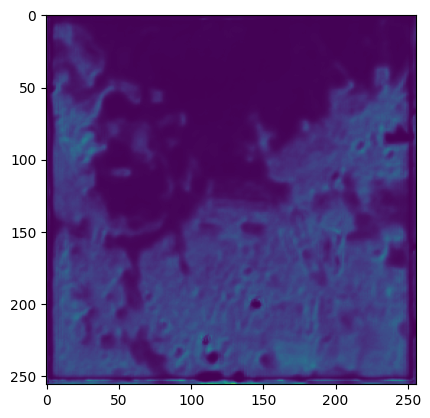

In [27]:
plt.imshow(output_data[0])

# R2-UNet model ONNX conversion

In [29]:
input_signature = [tf.TensorSpec([None,256,256,4], tf.float32, name='x')]
onnx_model, _ = tf2onnx.convert.from_keras(prune_r2unet, input_signature, opset=14)
onnx.save(onnx_model, "model_r2unet_p.onnx")

In [ ]:
sess = ort.InferenceSession("./working/model_r2unet_p.onnx", providers=["CUDAExecutionProvider"])
results_ort = sess.run(["r2unet_output_activation"], {"x":images.astype(np.float32) })

# Res-UNet model setup

In [32]:
import tensorflow as tf
from tensorflow.python.ops.gen_image_ops import resize_nearest_neighbor
import tensorflow.keras
from tensorflow.keras.models import *
from tensorflow.keras.layers import *
from tensorflow.keras.optimizers import *
from tensorflow.keras import backend as K
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import ModelCheckpoint, LearningRateScheduler
from tensorflow.keras.callbacks import ModelCheckpoint, LearningRateScheduler, EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.callbacks import ModelCheckpoint


In [33]:

def dice_coef(y_true, y_pred):
    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)
    intersection = K.sum(y_true_f * y_pred_f)
    return (2. * intersection + 1) / (K.sum(y_true_f) + K.sum(y_pred_f) + 1)


def dice_coef_loss(y_true, y_pred):
    return 1 - dice_coef(y_true, y_pred)


def jaccard_coef(y_true, y_pred):
    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)
    intersection = K.sum(y_true_f * y_pred_f)
    return (intersection + 1.0) / (K.sum(y_true_f) + K.sum(y_pred_f) - intersection + 1.0)


def jaccard_coef_loss(y_true, y_pred):
    return 1 - jaccard_coef(y_true, y_pred)



In [34]:
from tensorflow.keras.layers import Conv2D,Add,UpSampling2D,Concatenate

In [35]:
x=keras.layers.Input((256,256,4))
c1=Conv2D(filters=16,kernel_size=(3,3),padding="same",strides=1)(x)
c2=Conv2D(filters=16, kernel_size=(3,3), padding="same", strides=1)(c1)
c3=Conv2D(filters=16, kernel_size=(1, 1), padding="same", strides=1)(x)
s1=Add()([c2, c3])


c4=Conv2D(filters=32,kernel_size=(3,3),padding="same",strides=2)(s1)
c5=Conv2D(filters=32,kernel_size=(3,3),padding="same",strides=1)(c4)
c6=Conv2D(filters=32, kernel_size=(1, 1), padding="same", strides=2)(s1)
s2=Add()([c5, c6])

c7=Conv2D(filters=64,kernel_size=(3,3),padding="same",strides=2)(s2)
c8=Conv2D(filters=64,kernel_size=(3,3),padding="same",strides=1)(c7)
c9=Conv2D(filters=64, kernel_size=(1, 1), padding="same", strides=2)(s2)
s3=Add()([c8, c9])

c10=Conv2D(filters=128,kernel_size=(3,3),padding="same",strides=2)(s3)
c11=Conv2D(filters=128,kernel_size=(3,3),padding="same",strides=1)(c10)
c12=Conv2D(filters=128, kernel_size=(1, 1), padding="same", strides=2)(s3)
s4=Add()([c11, c12])

c13=Conv2D(filters=256,kernel_size=(3,3),padding="same",strides=2)(s4)
c14=Conv2D(filters=256,kernel_size=(3,3),padding="same",strides=1)(c13)
c15=Conv2D(filters=256, kernel_size=(1, 1), padding="same", strides=2)(s4)
s5=Add()([c14, c15])

b0=Conv2D(filters=256,kernel_size=(3,3),padding="same",strides=1)(s5)
b1=Conv2D(filters=256,kernel_size=(3,3),padding="same",strides=1)(b0)

u1=UpSampling2D((2,2))(b1)
u1=Concatenate()([u1,s4])
r1=Conv2D(filters=256,kernel_size=(3,3),padding="same",strides=1)(u1)
r2=Conv2D(filters=256,kernel_size=(3,3),padding="same",strides=1)(r1)
r3=Conv2D(filters=256, kernel_size=(1, 1), padding="same", strides=1)(u1)
rs1=Add()([r1, r3])


u2=UpSampling2D((2,2))(rs1)
u2=Concatenate()([u2,s3])
r1=Conv2D(filters=128,kernel_size=(3,3),padding="same",strides=1)(u2)
r2=Conv2D(filters=128,kernel_size=(3,3),padding="same",strides=1)(r1)
r3=Conv2D(filters=128, kernel_size=(1, 1), padding="same", strides=1)(u2)
rs2=Add()([r1, r3])


u3=UpSampling2D((2,2))(rs2)
u3=Concatenate()([u3,s2])
r1=Conv2D(filters=64,kernel_size=(3,3),padding="same",strides=1)(u3)
r2=Conv2D(filters=64,kernel_size=(3,3),padding="same",strides=1)(r1)
r3=Conv2D(filters=64, kernel_size=(1, 1), padding="same", strides=1)(u3)
rs3=Add()([r1, r3])


u4=UpSampling2D((2,2))(rs3)
u4=Concatenate()([u4,s1])
r1=Conv2D(filters=32,kernel_size=(3,3),padding="same",strides=1)(u4)
r2=Conv2D(filters=32,kernel_size=(3,3),padding="same",strides=1)(r1)
r3=Conv2D(filters=32, kernel_size=(1, 1), padding="same", strides=1)(u4)
rs4=Add()([r1, r3])

output=Conv2D(1, (1, 1), padding="same", activation="sigmoid")(rs4)


m=tensorflow.keras.models.Model(x,output)
m.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 256, 256, 4  0           []                               
                                )]                                                                
                                                                                                  
 conv2d (Conv2D)                (None, 256, 256, 16  592         ['input_1[0][0]']                
                                )                                                                 
                                                                                                  
 conv2d_1 (Conv2D)              (None, 256, 256, 16  2320        ['conv2d[0][0]']                 
                                )                                                             

In [40]:
def bn_act(x, act=True):
    x = tensorflow.keras.layers.BatchNormalization()(x)
    if act == True:
        x = tensorflow.keras.layers.Activation("relu")(x)
    return x
def conv_block(x, filters, kernel_size=(3, 3), padding="same", strides=1):
    conv = bn_act(x)
    conv = tensorflow.keras.layers.Conv2D(filters, kernel_size, padding=padding, strides=strides)(conv)
    return conv
def stem(x, filters, kernel_size=(3, 3), padding="same", strides=1):
    conv = tensorflow.keras.layers.Conv2D(filters, kernel_size, padding=padding, strides=strides)(x)
    conv = conv_block(conv, filters, kernel_size=kernel_size, padding=padding, strides=strides)
    
    shortcut = tensorflow.keras.layers.Conv2D(filters, kernel_size=(1, 1), padding=padding, strides=strides)(x)
    shortcut = bn_act(shortcut, act=False)
    
    output = tensorflow.keras.layers.Add()([conv, shortcut])
    return output
def residual_block(x, filters, kernel_size=(3, 3), padding="same", strides=1):
    res = conv_block(x, filters, kernel_size=kernel_size, padding=padding, strides=strides)
    res = conv_block(res, filters, kernel_size=kernel_size, padding=padding, strides=1)
    
    shortcut = tensorflow.keras.layers.Conv2D(filters, kernel_size=(1, 1), padding=padding, strides=strides)(x)
    shortcut = bn_act(shortcut, act=False)
    
    output = tensorflow.keras.layers.Add()([shortcut, res])
    return output
def upsample_concat_block(x, xskip):
    u = tensorflow.keras.layers.UpSampling2D((2, 2))(x)
    c = tensorflow.keras.layers.Concatenate()([u, xskip])
    return c
def ResUNet():
    f = [16, 32, 64, 128, 256]
    inputs = tensorflow.keras.layers.Input((256,256, 4))

    e0 = inputs
    e1 = stem(e0, f[0])
    e2 = residual_block(e1, f[1], strides=2)
    e3 = residual_block(e2, f[2], strides=2)
    e4 = residual_block(e3, f[3], strides=2)
    e5 = residual_block(e4, f[4], strides=2)
    

    b0 = conv_block(e5, f[4], strides=1)
    b1 = conv_block(b0, f[4], strides=1)

    u1 = upsample_concat_block(b1, e4)
    d1 = residual_block(u1, f[4])
    
    u2 = upsample_concat_block(d1, e3)
    d2 = residual_block(u2, f[3])
    
    u3 = upsample_concat_block(d2, e2)
    d3 = residual_block(u3, f[2])
    
    u4 = upsample_concat_block(d3, e1)
    d4 = residual_block(u4, f[1])
    
    outputs = tensorflow.keras.layers.Conv2D(1, (1, 1), padding="same", activation="sigmoid")(d4)
    model = tensorflow.keras.models.Model(inputs, outputs)
    return model
metrics = [dice_coef, 
           jaccard_coef,
           'binary_accuracy', 
           tf.keras.metrics.Precision(), 
           tf.keras.metrics.Recall()]
loss = ['binary_crossentropy',
         dice_coef_loss
       ]

        
model = ResUNet()
adam = tensorflow.keras.optimizers.Adam(1e-4)
model.compile(optimizer=adam, loss=dice_coef_loss, metrics=metrics)
#model.summary() 

In [41]:
model.summary()

Model: "model_2"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_3 (InputLayer)           [(None, 256, 256, 4  0           []                               
                                )]                                                                
                                                                                                  
 conv2d_60 (Conv2D)             (None, 256, 256, 16  592         ['input_3[0][0]']                
                                )                                                                 
                                                                                                  
 batch_normalization_28 (BatchN  (None, 256, 256, 16  64         ['conv2d_60[0][0]']              
 ormalization)                  )                                                           

In [16]:
model.save("fornetron.h5")

In [38]:
model.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 256, 256, 4  0           []                               
                                )]                                                                
                                                                                                  
 conv2d_30 (Conv2D)             (None, 256, 256, 16  592         ['input_2[0][0]']                
                                )                                                                 
                                                                                                  
 batch_normalization (BatchNorm  (None, 256, 256, 16  64         ['conv2d_30[0][0]']              
 alization)                     )                                                           

# Res-UNet model training

In [42]:
hist = model.fit(train_loader, epochs=100,
                    validation_data=val_loader,verbose=1)

Epoch 1/100
77/77 [==============================] - 35s 167ms/step - loss: 0.6651 - dice_coef: 0.3339 - jaccard_coef: 0.2331 - binary_accuracy: 0.9172 - precision_1: 0.1369 - recall_1: 0.8002 - val_loss: 0.9502 - val_dice_coef: 0.0498 - val_jaccard_coef: 0.0268 - val_binary_accuracy: 0.9595 - val_precision_1: 0.1283 - val_recall_1: 0.3194
Epoch 2/100
77/77 [==============================] - 9s 119ms/step - loss: 0.3014 - dice_coef: 0.6987 - jaccard_coef: 0.5549 - binary_accuracy: 0.9920 - precision_1: 0.7629 - recall_1: 0.7115 - val_loss: 0.9872 - val_dice_coef: 0.0126 - val_jaccard_coef: 0.0064 - val_binary_accuracy: 0.9858 - val_precision_1: 0.0000e+00 - val_recall_1: 0.0000e+00
Epoch 3/100
77/77 [==============================] - 9s 121ms/step - loss: 0.2905 - dice_coef: 0.7096 - jaccard_coef: 0.5718 - binary_accuracy: 0.9923 - precision_1: 0.7532 - recall_1: 0.7598 - val_loss: 0.9964 - val_dice_coef: 0.0036 - val_jaccard_coef: 0.0020 - val_binary_accuracy: 0.9858 - val_precision_1

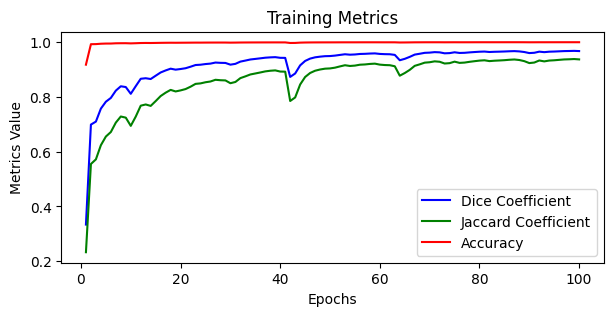

In [43]:
dice_coef_values = hist.history['dice_coef']
jaccard_coef_values = hist.history['jaccard_coef']
accuracy_values = hist.history['binary_accuracy']

epochs = range(1, 100 + 1)

# Plotting the metrics
plt.figure(figsize=(7, 3))

plt.plot(epochs, dice_coef_values, 'b', label='Dice Coefficient')
plt.plot(epochs, jaccard_coef_values, 'g', label='Jaccard Coefficient')
plt.plot(epochs, accuracy_values, 'r', label='Accuracy')


plt.title('Training Metrics')
plt.xlabel('Epochs')
plt.ylabel('Metrics Value')
plt.legend(loc='lower right')

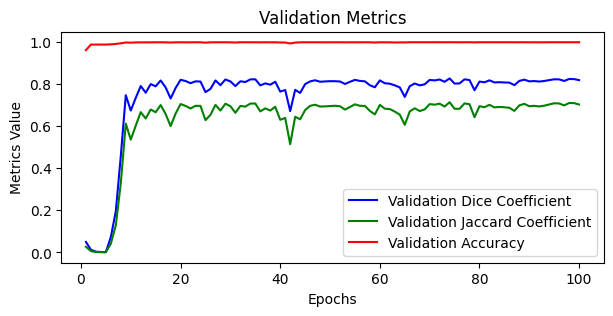

In [44]:

val_dice_coef_values = hist.history['val_dice_coef']
val_jaccard_coef_values = hist.history['val_jaccard_coef']
val_accuracy_values = hist.history['val_binary_accuracy']

epochs = range(1, 100 + 1)

# Plotting the metrics
plt.figure(figsize=(7, 3))

plt.plot(epochs, val_dice_coef_values, 'b', label='Validation Dice Coefficient')
plt.plot(epochs, val_jaccard_coef_values, 'g', label='Validation Jaccard Coefficient')
plt.plot(epochs, val_accuracy_values, 'r', label='Validation Accuracy')

plt.title('Validation Metrics')
plt.xlabel('Epochs')
plt.ylabel('Metrics Value')
plt.legend(loc='lower right')

plt.show()

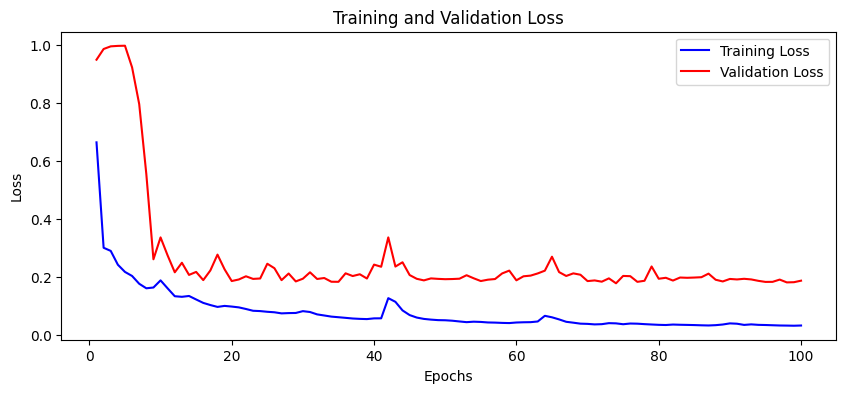

In [46]:
train_loss = hist.history['loss']
val_loss = hist.history['val_loss']

epochs = range(1, len(train_loss) + 1)

plt.figure(figsize=(10, 4))

plt.plot(epochs, train_loss, 'b', label='Training Loss')
plt.plot(epochs, val_loss, 'r', label='Validation Loss')

plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

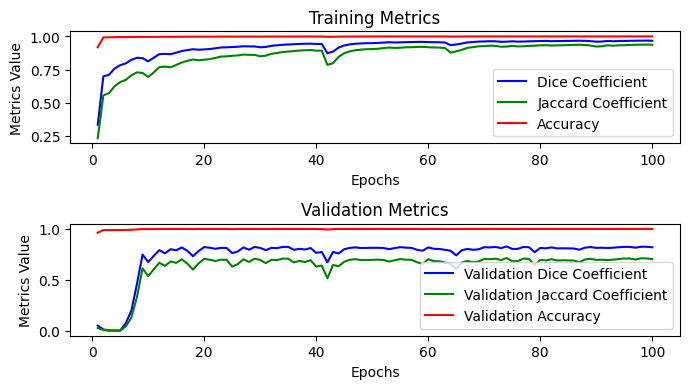

In [47]:

# Training Metrics
plt.figure(figsize=(7, 4))

plt.subplot(2, 1, 1)
plt.plot(epochs, dice_coef_values, 'b', label='Dice Coefficient')
plt.plot(epochs, jaccard_coef_values, 'g', label='Jaccard Coefficient')
plt.plot(epochs, accuracy_values, 'r', label='Accuracy')

plt.title('Training Metrics')
plt.xlabel('Epochs')
plt.ylabel('Metrics Value')
plt.legend(loc='lower right')

# Validation Metrics
plt.subplot(2, 1, 2)
plt.plot(epochs, val_dice_coef_values, 'b', label='Validation Dice Coefficient')
plt.plot(epochs, val_jaccard_coef_values, 'g', label='Validation Jaccard Coefficient')
plt.plot(epochs, val_accuracy_values, 'r', label='Validation Accuracy')

plt.title('Validation Metrics')
plt.xlabel('Epochs')
plt.ylabel('Metrics Value')
plt.legend(loc='lower right')

plt.tight_layout()
plt.show()


# Res-UNet model pruning

In [48]:
import tensorflow_model_optimization as tfmot
pruning_params = {
    'pruning_schedule': tfmot.sparsity.keras.PolynomialDecay(
        initial_sparsity=0.3,
        final_sparsity=0.5,   
        begin_step=0,
        end_step=5000
    )
}

model_for_pruning = tfmot.sparsity.keras.prune_low_magnitude(model, **pruning_params)
model_for_pruning.compile(optimizer=Adam(1e-4), loss=dice_coef_loss, metrics=metrics)
#model_for_pruning.summary()
model.save("unpruned.h5")

In [ ]:
callbacks = [
  tfmot.sparsity.keras.UpdatePruningStep(),
]

history_prune=model_for_pruning.fit(train_loader, epochs=50,
                    validation_data=val_loader,verbose=1,callbacks=callbacks)

In [ ]:
dice_coef_values = history_prune.history['dice_coef']
jaccard_coef_values = history_prune.history['jaccard_coef']
accuracy_values = history_prune.history['binary_accuracy']



val_dice_coef_values = history_prune.history['val_dice_coef']
val_jaccard_coef_values = history_prune.history['val_jaccard_coef']
val_accuracy_values = history_prune.history['val_binary_accuracy']
epochs = range(1, 50 + 1)

plt.figure(figsize=(7, 4))

plt.subplot(2, 1, 1)
plt.plot(epochs, dice_coef_values, 'b', label='Dice Coefficient')
plt.plot(epochs, jaccard_coef_values, 'g', label='Jaccard Coefficient')
plt.plot(epochs, accuracy_values, 'r', label='Accuracy')

plt.title('Training Metrics')
plt.xlabel('Epochs')
plt.ylabel('Metrics Value')
plt.legend(loc='lower right')

# Validation Metrics
plt.subplot(2, 1, 2)
plt.plot(epochs, val_dice_coef_values, 'b', label='Validation Dice Coefficient')
plt.plot(epochs, val_jaccard_coef_values, 'g', label='Validation Jaccard Coefficient')
plt.plot(epochs, val_accuracy_values, 'r', label='Validation Accuracy')

plt.title('Validation Metrics')
plt.xlabel('Epochs')
plt.ylabel('Metrics Value')
#plt.legend(loc='lower right')

plt.tight_layout()
plt.show()


In [52]:
model_for_export = tfmot.sparsity.keras.strip_pruning(model_for_pruning)
_, pruned_keras_file = tempfile.mkstemp('.h5')
tf.keras.models.save_model(model_for_export, pruned_keras_file, include_optimizer=False)
print('Saved pruned Keras model to:', pruned_keras_file)
model_for_export.save('pruned_model_res.h5')

Saved pruned Keras model to: /tmp/tmpb1ksd787.h5


In [53]:
prune_resnet=load_model('./working/pruned_model_res.h5')

1/1 [==============================] - 1s 533ms/step


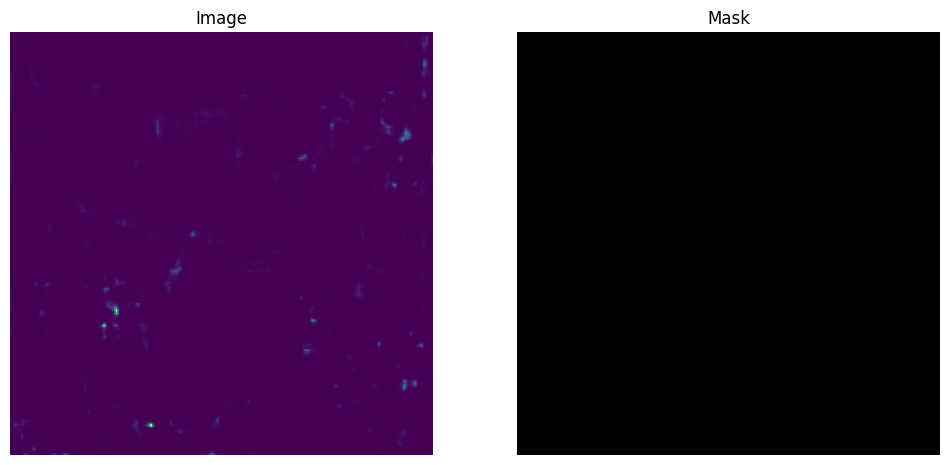

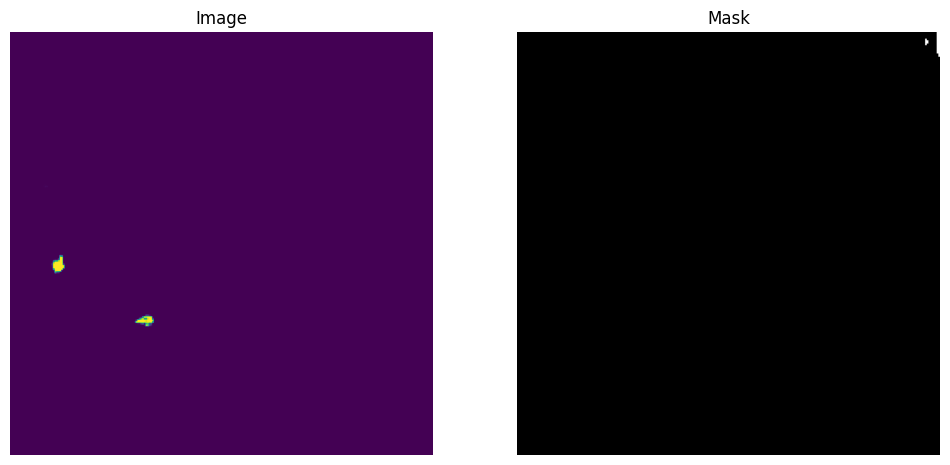

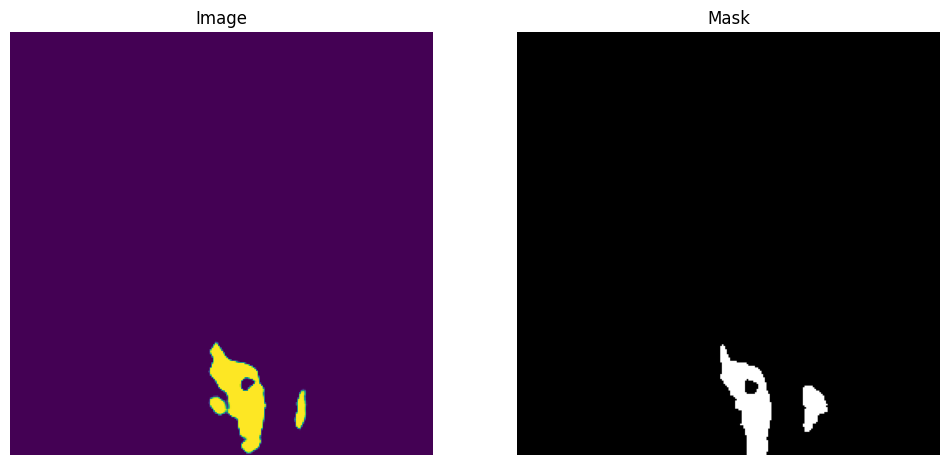

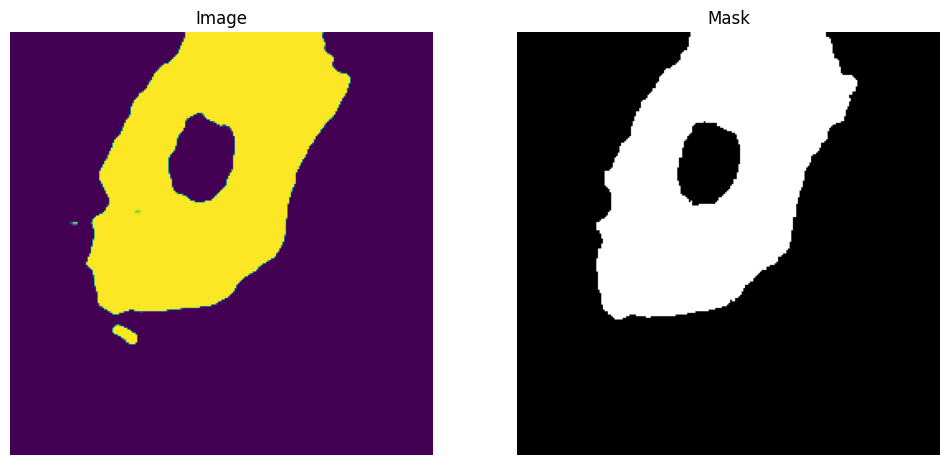

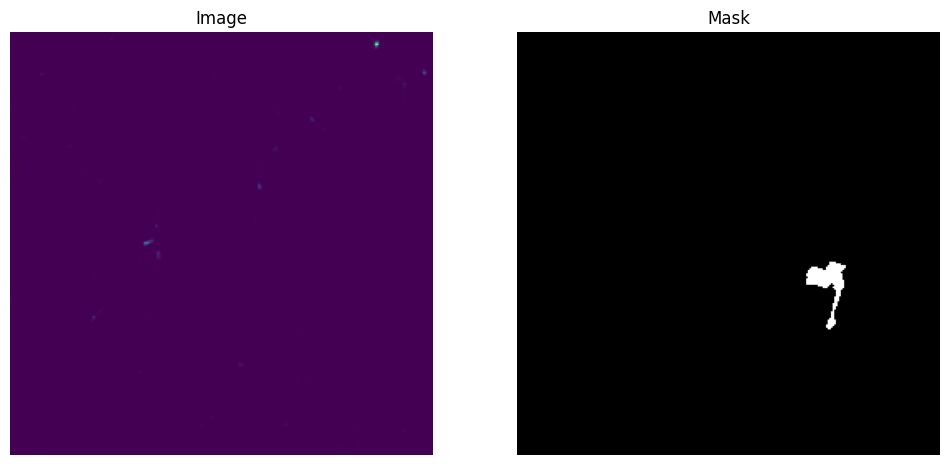

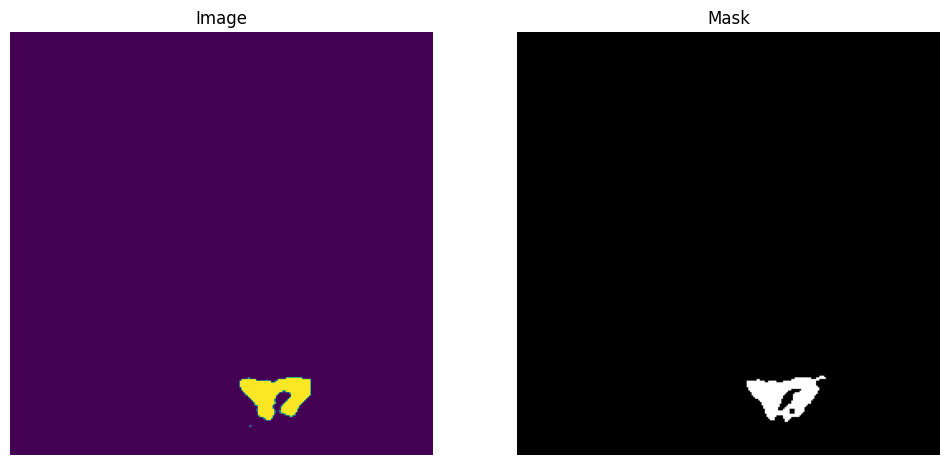

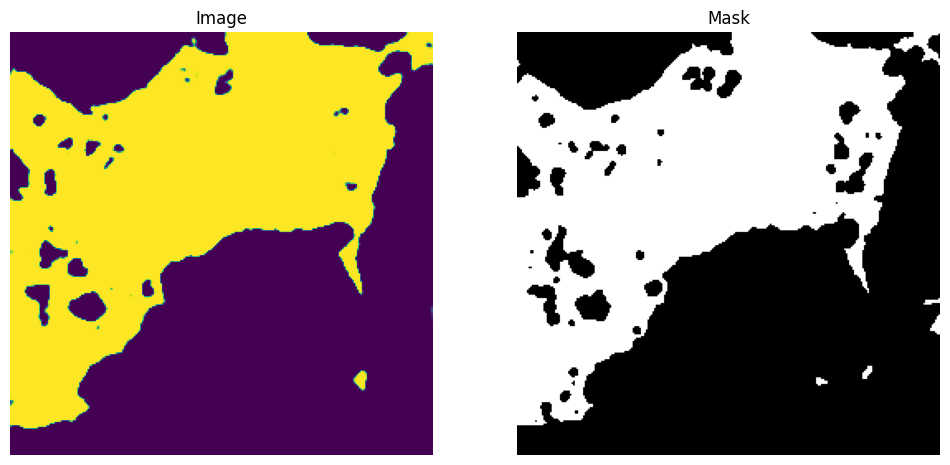

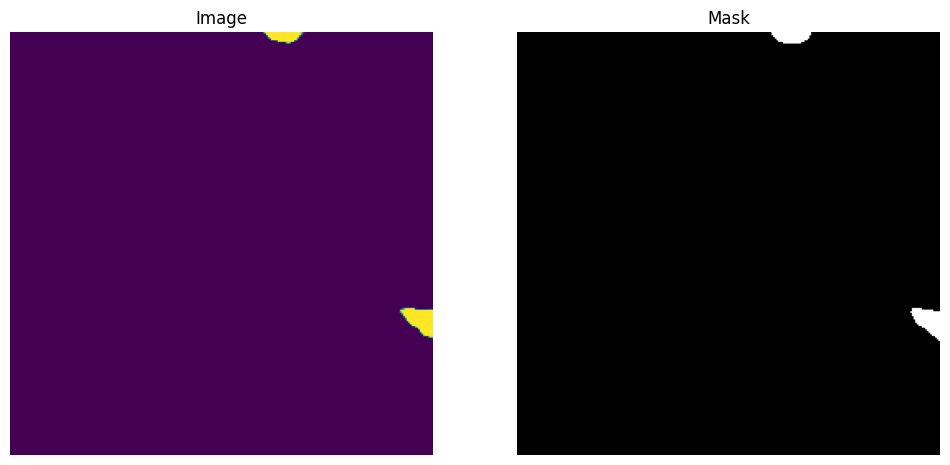

In [54]:
idx=5
sample_batch = val_loader[idx]
images, masks = sample_batch
out=prune_resnet.predict(images)
sample_batch = val_loader[idx]
images, masks = sample_batch
for i in range(len(images)):
    plt.figure(figsize=(12, 6))

    plt.subplot(1, 2, 1)
    plt.imshow(out[i])
    plt.title('Image')
    plt.axis('off')

    plt.subplot(1, 2, 2)
    plt.imshow(masks[i][:, :, 0], cmap='gray')  # Assuming binary masks
    plt.title('Mask')
    plt.axis('off')

    plt.show()

In [55]:
prune=load_model('./working/pruned_model_res.h5')
s=time.time()
prune.predict(val_loader)
e=time.time()
print(e-s)

20/20 [==============================] - 1s 43ms/step
1.5034756660461426


# Res-UNet model quantization

In [57]:
model = tf.keras.models.load_model('./working/pruned_model_res.h5')

converter = tf.lite.TFLiteConverter.from_keras_model(model)
converter.optimizations = [tf.lite.Optimize.DEFAULT]  
quantized_tflite_model = converter.convert()

with open('quantized_model_new.tflite', 'wb') as f:
    f.write(quantized_tflite_model)

In [62]:

interpreter = tf.lite.Interpreter(model_path='./working/quantized_model.tflite')
interpreter.allocate_tensors()

input_details = interpreter.get_input_details()
output_details = interpreter.get_output_details()

#input_data = np.random.randn(1, input_details[0]['shape'][1]).astype(np.float32)

interpreter.set_tensor(input_details[0]['index'], np.expand_dims(images[1],axis=0).astype(np.float32))

interpreter.invoke()

output_data = interpreter.get_tensor(output_details[0]['index'])
print("Output:", output_data.shape)


Output: (1, 256, 256, 1)


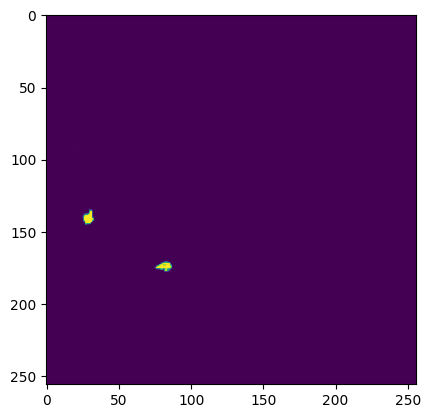

In [63]:
plt.imshow(output_data[0])

# Res-UNet model ONNX conversion

In [69]:
input_signature = [tf.TensorSpec([None,256,256,4], tf.float32, name='x')]
onnx_model, _ = tf2onnx.convert.from_keras(model, input_signature, opset=14)
onnx.save(onnx_model, "model.onnx")

In [70]:
input_signature = [tf.TensorSpec([None,256,256,4], tf.float32, name='x')]
onnx_model, _ = tf2onnx.convert.from_keras(model_for_export, input_signature, opset=14)
onnx.save(onnx_model, "model.onnx")

In [ ]:
sess = ort.InferenceSession("./working/model.onnx", providers=["CUDAExecutionProvider"])
results_ort = sess.run(["conv2d_29", "conv2d_29"], {"x": np.expand_dims(i[3].astype(np.float32),axis=0)})